In [1]:
import numpy as np
import pandas as pd
from nltk import word_tokenize,sent_tokenize
from collections import deque
import random
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import random
from numpy import pi

Using TensorFlow backend.


In [310]:
def generate_trajectory():
    
    Vy_0 = 1+random.random()*2
    Vx_0 = 1+random.random()*2
    h_0 = random.random()

    g = -9.81

    tau = (-Vy_0 - np.sqrt(Vy_0**2 - 2*g*h_0))/g

    time = np.arange(0,tau,1e-2)

    Vx = Vx_0
    Vy = Vy_0 + g*time

    x = Vx_0*time
    y = Vy_0*time + 0.5*g*time**2 + h_0
    
    x = np.reshape(x, (-1,1))
    y = np.reshape(y, (-1,1))

    return x,y

In [95]:
data_path_steps = 100

def generate_circles():
    r = random.random()
    #r = 1
    start = random.random()*2*pi
    end = start + 2*pi
    
    theta = np.linspace(start,end,data_path_steps)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    
    x = np.reshape(x, (-1,1))
    y = np.reshape(y, (-1,1))
    
    return x,y
    

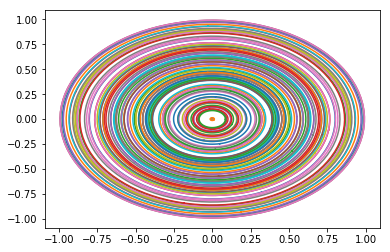

In [96]:
data = []
num_sets = 100
for n in range (num_sets):

    #x,y = generate_trajectory()
    x,y = generate_circles()
    
    x_y = np.concatenate((x,y), axis = 1)
    data.append(x_y)

    plt.plot(x,y)

In [97]:
sequential_data = []

memory = 10
for m in range(len(data)):
    
    x_y = data[m]
    n = 0
    while n + memory <= len(x_y):
        sequential_data.append(x_y[n:n+memory])
        n+=1


In [98]:
np.array(sequential_data).shape

(9100, 10, 2)

In [99]:
random.shuffle(sequential_data)

training_frac = 0.1
index = int(training_frac*len(sequential_data))


train_data = sequential_data[:-index]
test_data = sequential_data[-index:]

In [100]:
def target_data_split(data):
    X = [None]*len(data)
    y = [None]*len(data)
    
    for n in range(len(data)):
        X[n], y[n] = data[n][:-1], data[n][-1]  
    return np.array(X), np.array(y)             

X_train, y_train = target_data_split(train_data)      
X_test, y_test = target_data_split(test_data)


In [101]:
X_train.shape,y_train.shape

((8190, 9, 2), (8190, 2))

In [102]:
model = Sequential()

model.add(LSTM(128, input_shape = (np.array(X_train)[0].shape)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(2, activation = "linear"))

optimizer = RMSprop(lr=1e-3,decay = 1e-5)
model.compile(loss='mse', optimizer=optimizer, metrics=["acc"])

In [112]:
epochs = 10
batch_size = 128
history = model.fit(X_train,y_train, batch_size = batch_size, epochs=epochs,validation_data=(X_test,y_test))

Train on 8190 samples, validate on 910 samples
Epoch 1/10
8190/8190 [==============================] - 2s 250us/step - loss: 0.0080 - acc: 0.9420 - val_loss: 0.0022 - val_acc: 0.9593
Epoch 2/10
8190/8190 [==============================] - 2s 249us/step - loss: 0.0080 - acc: 0.9426 - val_loss: 4.6245e-04 - val_acc: 0.9879
Epoch 3/10
8190/8190 [==============================] - 2s 228us/step - loss: 0.0075 - acc: 0.9394 - val_loss: 5.2911e-04 - val_acc: 0.9725
Epoch 4/10
8190/8190 [==============================] - 2s 259us/step - loss: 0.0071 - acc: 0.9471 - val_loss: 5.4316e-04 - val_acc: 0.9681
Epoch 5/10
8190/8190 [==============================] - 2s 231us/step - loss: 0.0072 - acc: 0.9441 - val_loss: 0.0020 - val_acc: 0.9604
Epoch 6/10
8190/8190 [==============================] - 3s 311us/step - loss: 0.0070 - acc: 0.9448 - val_loss: 0.0024 - val_acc: 0.9912
Epoch 7/10
8190/8190 [==============================] - 4s 471us/step - loss: 0.0071 - acc: 0.9448 - val_loss: 0.0013 - val_a

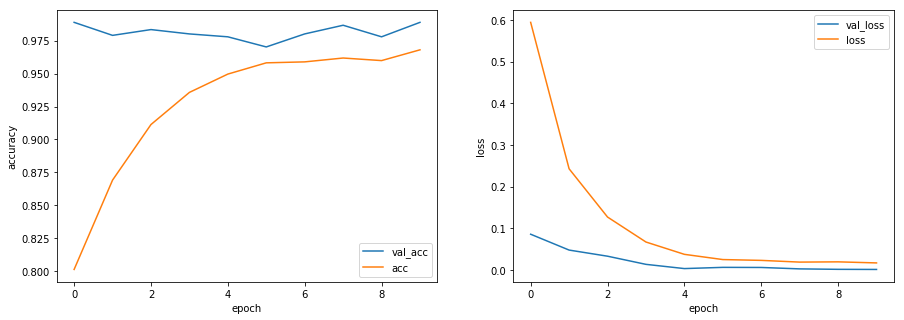

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,5))

epochs

plt.subplot(1,2,1)
plt.plot(history.history["val_acc"])
plt.plot(history.history["acc"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["val_acc","acc"])

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["val_loss","loss"])

In [113]:
def generate_path(key:str, memory=memory,path_length = 200 ):
    
    if key == "circle":
        
        x,y = generate_circles()
        
        true_path = np.concatenate((x,y), axis = 1)
        
        x = x[:memory-1]
        y = y[:memory-1]

        
    elif key =="trajectory":
        
        x,y = generate_trajectory()
        
        true_path = np.concatenate((x,y), axis = 1)
        
        x = x[:memory-1]
        y = y[:memory-1]
        
    
    x_y = np.concatenate((x,y), axis = 1)
    
    path = x_y    
    
    x_y = np.reshape(x_y,(1,) + x_y.shape)
    
    for n in range(path_length):
        
        next_coordinate = model.predict(x_y)
        path = np.concatenate((path,next_coordinate), axis = 0)
        
        next_coordinate = np.reshape(next_coordinate, (1,) + next_coordinate.shape)
        
        x_y = np.concatenate((x_y,next_coordinate), axis = 1)
        x_y = np.delete(x_y,obj =0, axis = 1)
    
    
    return path, true_path

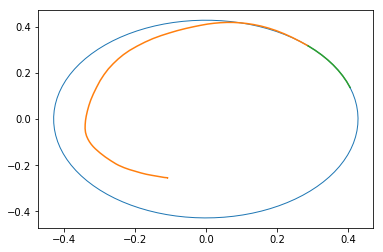

In [134]:
path,true_path = generate_path("circle", path_length=2000)
plt.plot(true_path[:,0],true_path[:,1], LineWidth = 1)
plt.plot(path[memory-2:,0],path[memory-2:,1])
plt.plot(path[:memory-1,0],path[:memory-1,1])
#plt.savefig("r=1_circle_wrong_path.png")

# Progressive training

We train the network sequentially, with progressively smaller learning rate. The red line is the seed line, which the network uses to predict the next point on the curve. The yellow curve is the one predicted by the network, while the blue curve is the target trajectory (a circle with radius 1)

Training with a learning rate of $lr = 1e-2$ for 10 epochs, gives us the result below. The orange trajectory generated by the network is a poor fit to the target circle, but at least it has learned to go counter-clockwize (all the training data is counter-clockwize trajectories).
![test](r=1_circle_underfitted_2.png)

Training for 10 more epochs, on the same network with the same learning rate, nets us the resut shown below. The network now generates something that looks like a circle, but it is still not a perfect fit to the training data.
![title](r=1_circle_underfitted_3.png)

After 10 more epochs, with a learning rate of $lr = 1e-3$, we are getting close to a perfect circle.

![title](r=1_circle_underfitted.png)


And after the final 10 epochs, we get as good result as I'm willing to look for.
![title](r=1_circle_overfitted_1.png)

Essentially, the network has learned to finish drawing in a circle, if we give it a seed which is a segment of the circle which was the training data. If we feed it a seed it has not seen before, we get the following results.

![title](r=1_circle_wrong_path.png)

# Uniformly sampled radius for input data